# Monte Carlo - Standoff Calculation

See Monte Carlo - Arrhenius Degredation for a more in depth guide. Steps will be shortened for brevity.
This journal applies a Monte Carlo to the Standoff Calculation


In [ ]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
# !pip install pvdeg

In [2]:
import pvlib
import numpy as np
import pandas as pd
import pvdeg
import matplotlib.pyplot as plt

In [3]:
# This information helps with debugging and getting support :)
import sys
import platform

print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("Pvlib version ", pvlib.__version__)
print("Pvdeg version ", pvdeg.__version__)

Working on a  Windows 11
Python version  3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:16) [MSC v.1929 64 bit (AMD64)]
Pandas version  2.2.3
Pvlib version  0.13.0
Pvdeg version  0.5.1.dev623+g51cc68b8e.d20250905


# Simple Standoff Calculation

This is copied from another tutorial called `4 - Standards.ipynb`, please visit this page for a more in depth explanation of the process for a single standoff calculation.

<div class="alert alert-block alert-info">
<b>Please use your own API key: The block below makes an NSRDB API to get weather and meta data. This tutorial will work with the DEMO Key provided, but it will take you less than 3 minutes to obtain your own at <a ref="https://developer.nrel.gov/signup/">https://developer.nrel.gov/signup/</a> so register now.)
</div>

In [4]:
weather_db = "PSM4"
weather_id = (40.633365593159226, -73.9945801019899)  # Manhattan, NYC
weather_arg = {
    "api_key": "DEMO_KEY",
    "email": "user@mail.com",
    "map_variables": True,
}

WEATHER, META = pvdeg.weather.get(weather_db, weather_id, **weather_arg)


 Column "relative_humidity" not found in DataFrame. Calculating...


In [5]:
# simple standoff calculation
height1 = pvdeg.standards.standoff(weather_df=WEATHER, meta=META)

# more arguments standoff calculation
height2 = pvdeg.standards.standoff(
    weather_df=WEATHER,
    meta=META,
    tilt=None,
    azimuth=180,
    sky_model="isotropic",
    temp_model="sapm",
    x_0=6.1,
    wind_factor=0.33,  # default
)

print(height1)
print(height2)

The array surface_tilt angle was not provided, therefore the latitude of  40.6 was used.
The array azimuth was not provided, therefore an azimuth of  180.0 was used.


The array surface_tilt angle was not provided, therefore the latitude of  40.6 was used.
          x      T98_0    T98_inf
0  0.522443  71.778148  48.754265
          x      T98_0    T98_inf
0  0.490293  71.778148  48.754265


# Defining Correlation Coefficients, Mean and Standard Deviation For Monte Carlo Simulation

We will leave the list of correlations blank because our variables are not correlated. For a correlated use case visit the `Monte Carlo - Arrhenius.ipynb` tutorial.

Mean and standard deviation must always be populated if being used to create a dataset. However, you can feed your own correlated or uncorrelated data into the simulate function but column names must be consistent.

In [6]:
# These numbers may not make sense in the context of the problem but work for demonstraiting the process
stats = {"X_0": {"mean": 5, "stdev": 3}, "wind_factor": {"mean": 0.33, "stdev": 0.5}}

corr_coeff = []

samples = pvdeg.montecarlo.generateCorrelatedSamples(corr_coeff, stats, 500)

In [7]:
print(samples)

           X_0  wind_factor
0     5.446054     0.840997
1     5.359594     1.211375
2    11.594215     1.156407
3     2.465918     0.879600
4     5.715569    -0.346758
..         ...          ...
495   3.122957     0.095630
496   9.772415     0.656821
497   9.032370     0.423069
498   5.854381     0.533933
499   7.910730     0.306565

[500 rows x 2 columns]


# Standoff Monte Carlo Inputs

When using the pvdeg.montecarlo.simulate() function on a target function all of the target function's required arguments must still be given. Our non-changing arguments will be stored in a dictionary. The randomized monte carlo input data will also be passed to the target function via the simulate function. All required target function arguments should be contained between the column names of the randomized input data and fixed argument dictionary,

In [8]:
# defining arguments to pass to the target function, standoff() in this case
function_kwargs = {
    "weather_df": WEATHER,
    "meta": META,
    "azimuth": 180,
    "tilt": 0,
    "temp_model": "sapm",
    "sky_model": "isotropic",
    "conf_0": "insulated_back_glass_polymer",
    "conf_inf": "open_rack_glass_polymer",
    "T98": 70,
    "irradiance_kwarg": {},
    "conf_0_kwarg": {},
    "conf_inf_kwarg": {},
    "model_kwarg": {},
}

# notice how we left off parts we want to use in the monte carlo simulation because they are already contained in the dataframe

results = pvdeg.montecarlo.simulate(
    func=pvdeg.standards.standoff,
    correlated_samples=samples,
    **function_kwargs,
)

# Dealing With Series
Notice how our results are contained in a pandas series instead of a dataframe.

This means we have to do an extra step to view our results. Run the block below to confirm that our results are indeed contained in a series. And convert them into a simpler dataframe.

In [9]:
print(type(results))

# Convert from pandas Series to pandas DataFrame
results_df = pd.concat(results.tolist()).reset_index(drop=True)

<class 'pandas.core.series.Series'>


In [10]:
print(results_df)

            x      T98_0    T98_inf
0    0.000000  62.875979  43.220795
1    0.000000  55.251818  39.225413
2    0.000000  56.521287  39.830162
3    0.000000  62.210649  42.846511
4    1.308158  74.809714  51.298730
..        ...        ...        ...
495  0.280614  71.924493  49.530114
496  0.000000  65.746234  45.130073
497  0.000000  68.672469  47.319254
498  0.000000  67.473095  46.294197
499  0.000000  69.936295  48.130621

[500 rows x 3 columns]


# Viewing Our Data
Let's plot the results using a histogram

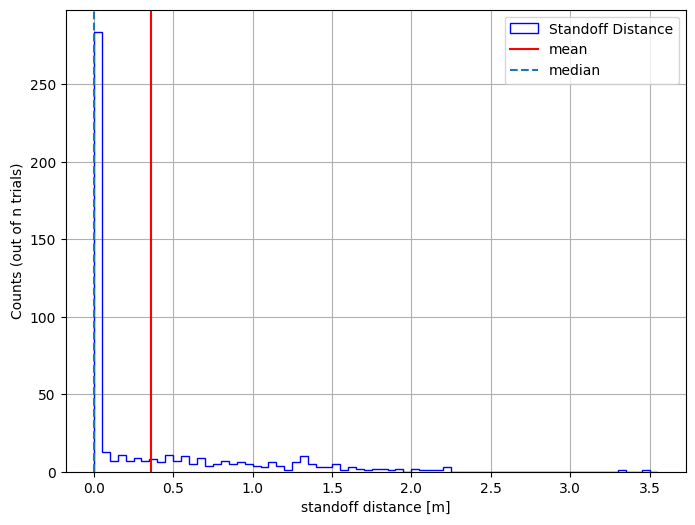

In [11]:
bin_edges = np.arange(results_df["x"].min(), results_df["x"].max() + 0.1, 0.05)
plt.figure(figsize=(8, 6))
plt.hist(
    results_df["x"],
    bins=bin_edges,
    edgecolor="blue",
    histtype="step",
    linewidth=1,
    label="Standoff Distance",
)
plt.ylabel("Counts (out of n trials)")
plt.xlabel("standoff distance [m]")
plt.axvline(np.mean(results_df["x"]), color="red", label="mean")
plt.axvline(np.median(results_df["x"]), linestyle="--", label="median")

plt.legend()
plt.grid(True)
plt.show()